# Прогнозирование оттока клиентов банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### План работы
1. Открытие файла с данными и его изучение. Подготовка данных.
2. Исследование задачи.
3. Борьба с дисбалансом.
4. Тестирование модели.

# 1. Подготовка данных

Начнем с визуального изучения данных.

In [4]:
import pandas as pd #Импрортирую библиотеку Pandas
%matplotlib inline
import matplotlib.pyplot as plt #Импортирую библиотеку matplotlib
import seaborn as sns #Импортирую библиотеку seaborn
#Открываю датасет
data = pd.read_csv('/datasets/Churn.csv')
#data = data.style.background_gradient(cmap='coolwarm')
data.columns = data.columns.str.lower() #Привожу названия столбцов к нижнему регистру

data.info() #Получаю информацию о датасете
print()
#Печатаю датасет
display(data.head(10).style.background_gradient(cmap='coolwarm'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB



,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
2,3,15619304,Onio,502,France,Female,42,8,159661,3,1,0,113932,1
3,4,15701354,Boni,699,France,Female,39,1,0,2,0,0,93826.6,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
5,6,15574012,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
6,7,15592531,Bartlett,822,France,Male,50,7,0,2,1,1,10062.8,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
8,9,15792365,He,501,France,Male,44,4,142051,2,0,1,74940.5,0
9,10,15592389,H?,684,France,Male,27,2,134604,1,1,1,71725.7,0


### Промежуточный вывод

Для построения модели прогнозирующей отток клиентов банка предоставлен датасет, состоящий из 14 столбцов с данными и 10000 строк. 

<br>Каждый объект в наборе данных — это информация об одном клиенте. Известно:

<br>• rownumber — индекс строки в данных
<br>• customerId — уникальный идентификатор клиента
<br>• surname — фамилия
<br>• creditscore — кредитный рейтинг
<br>• geography — страна проживания
<br>• gender — пол
<br>• age — возраст
<br>• tenure — количество недвижимости у клиента
<br>• balance — баланс на счёте
<br>• numofproducts — количество продуктов банка, используемых клиентом
<br>• hascrcard — наличие кредитной карты
<br>• isactivemember — активность клиента
<br>• estimatedsalary — предполагаемая зарплата
<br>• exited — факт ухода клиента (Уход — 1, НЕ уход — 0)

Целевым признаком является столбец *'Exited'*, именно его будет стараться предсказать наша модель.
В столбце *'Tenure'* имеются пропуски данных, датасет требует подготовки для посторения модели.

In [2]:
#Провожу анализ пропущенных значений
print('Доля пропусков в столбце tenure:', sum(data['tenure'].isnull())/len(data['tenure'])*100,'%')
print()
print('Значения в столбце tenure:')
print(data['tenure'].value_counts())
print()
print('Среднее значение в столбце tenure:', round(data['tenure'].mean()))
print()
print(data.corr()) #Строю матрицу корреляции

Доля пропусков в столбце tenure: 9.09 %

Значения в столбце tenure:
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Среднее значение в столбце tenure: 5

                 rownumber  customerid  creditscore       age    tenure  \
rownumber         1.000000    0.004202     0.005840  0.000783 -0.007322   
customerid        0.004202    1.000000     0.005308  0.009497 -0.021418   
creditscore       0.005840    0.005308     1.000000 -0.003965 -0.000062   
age               0.000783    0.009497    -0.003965  1.000000 -0.013134   
tenure           -0.007322   -0.021418    -0.000062 -0.013134  1.000000   
balance          -0.009067   -0.012419     0.006268  0.028308 -0.007911   
numofproducts     0.007246    0.016972     0.012238 -0.030680  0.011979   
hascrcard         0.000599   -0.014025    -0.005458 -0.011721  0.027232   
isactivemember    0.012044    0.001665     0.025651  0.0854

Как видно из результатов анализа пропущенных значений, в столбце *'tenure'* имеется 9,09% пропущенных значений. Среднее значение в столбце составлет 5, но при этом матрица корреляции не выявила зависимостей между количеством недвижимости клиента и другими параметрами, такими как, например, баланс на счёте или предполагаемая зарплата. Одним из наиболее очевидных способов обработки пропусков данных в этом столбце будет замена их на 0, предполагая, что у этих клинтов отсутствует недвижимость

<br>Также, очевидно, что не все столбцы датасета являются необходимыми признаками для обучения модели, в связи с этим удаляю столбцы *'RowNumber', 'CustomerId', 'Surname'.* 

In [3]:
data = data.fillna(0) #Заменяю пропуски на 0
data.drop(['rownumber','customerid', 'surname'], axis='columns', inplace=True) #Удаляю ненужные столбцы

display(data.head())
data.info() #Получаю информацию о датасете

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Поскольку целевым признаком является факт ухода/НЕ ухода клиента, оценим баланс классов.

Количество клиентов ушедших (1), НЕ ушедших (0)
0    7963
1    2037
Name: exited, dtype: int64
Доля клиентов ушедших (1), НЕ ушедших (0)
0    0.7963
1    0.2037
Name: exited, dtype: float64


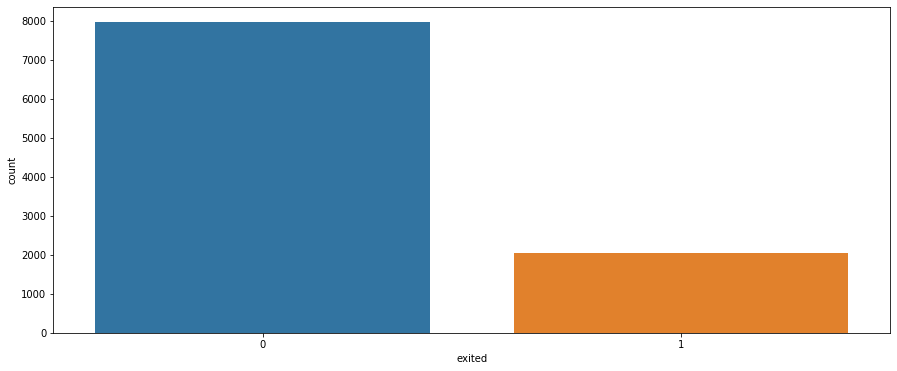

In [4]:
#Определяю количество ушедших (1) и оставшихся (0) клиентов
print('Количество клиентов ушедших (1), НЕ ушедших (0)')
print(data['exited'].value_counts())
print('Доля клиентов ушедших (1), НЕ ушедших (0)')
print(data['exited'].value_counts(normalize = True))
#Для наглядности строю график
plt.figure(figsize=(15, 6))
sns.countplot(x='exited', data=data)

Из расчетов и графика виден определенный дисбаланс классов ушедших клиентов почти в 4 раза меньше, чем оставшихся.

Продолжим подготовку данных для обучения модели. Категориальные признаки присутствуют в двух столбцах датасета - *'geography'*  и *'gender'*. Изучим их.

In [5]:
print('Уникальные значения в столбе geography:', data['geography'].unique())
print('Уникальные значения в столбе gender:', data['gender'].unique())

Уникальные значения в столбе geography: ['France' 'Spain' 'Germany']
Уникальные значения в столбе gender: ['Female' 'Male']


Преобразовать категориальные признаки в столбцах *'gender'* и *'geography'* в численные поможет техника прямого кодирования - OHE (англ. One-Hot Encoding).

In [6]:
data = pd.get_dummies(data, drop_first = True) #Применяю технику OHE, первый столбец сбрасываю

In [7]:
#Перемещу столбец с целевым признаком в конец датафрейма
cols = data.columns.tolist()
cols.remove('exited')
cols.insert(11, 'exited')
data = data[cols]
#return df[cols]

display(data.head())
data.info() #Получаю информацию о датасете

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male,exited
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0,1
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0,1
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
creditscore          10000 non-null int64
age                  10000 non-null int64
tenure               10000 non-null float64
balance              10000 non-null float64
numofproducts        10000 non-null int64
hascrcard            10000 non-null int64
isactivemember       10000 non-null int64
estimatedsalary      10000 non-null float64
geography_Germany    10000 non-null uint8
geography_Spain      10000 non-null uint8
gender_Male          10000 non-null uint8
exited               10000 non-null int64
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Финальным шагом подготовки данных будет масштабирование признаков методом стандартизации. Для этого сперва разделим исходный датасет на выборки в соотношении 3:1:1.

In [8]:
target = data['exited'] #Выделяю целевой признак
features = data.loc[:,'creditscore':'gender_Male'] #Выделяю признаки

In [9]:
from sklearn.model_selection import train_test_split #Импортирую функцию train_test_split из библиотеки sklearn
from sklearn.preprocessing import StandardScaler #Импортирую StandardScaler из библиотеки sklearn

#Разделяю датасет на тренировочную и валидационно/тестовую выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target) 

#Разделяю валидационно/тестовую выборку на валидационно и тестовую выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify = target_valid_test)

In [10]:
#Составляю список с чиловыми признаками
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler() 
scaler.fit(features_train.loc[:,numeric]) #Обучаю стандартизатор

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
#Стандартизирую признаки

features_train[numeric] = scaler.transform(features_train.loc[:,numeric])
features_valid.loc[:,numeric] = scaler.transform(features_valid.loc[:,numeric])
features_test.loc[:,numeric] = scaler.transform(features_test.loc[:,numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [12]:
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.467449,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.461501,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.110432,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-1.461501,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.140009,0.879129,-0.914708,1,0,0.113236,0,0,0


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
6612,-1.524838,2.383160,-0.497026,1.011655,-0.914708,0,1,0.010275,0,0,0
519,0.587990,1.811221,0.467449,0.213192,-0.914708,0,1,0.453089,0,0,1
1609,-0.318980,-0.381213,1.110432,0.893896,-0.914708,1,0,-0.603508,0,0,0
3475,1.226991,-0.762506,-0.175534,-0.240363,0.820981,1,1,-1.621460,0,0,1
2707,-0.133464,-0.095244,-0.497026,0.447305,-0.914708,0,0,0.338574,0,0,0


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
657,-0.504497,1.429928,-1.140009,0.873883,0.820981,1,1,1.725255,1,0,0
2083,-1.195031,-1.429769,-1.140009,-1.219673,-0.914708,1,1,1.203665,0,0,1
3234,-1.267176,0.762665,-1.140009,-1.219673,-0.914708,1,0,-1.374743,0,0,1
1551,0.825039,1.239281,0.788940,-1.219673,0.820981,0,1,0.382306,0,1,0
2344,0.660135,0.953312,-0.175534,0.267087,-0.914708,1,0,-1.613578,1,0,0


Для верности проверим выборки.

In [13]:
print('Обучающая выборка:', features_train.shape)
print('Обучающая выборка - целевой признак:', target_train.shape)
print('Валидационная выборка выборка:', features_valid.shape)
print('Валидационная выборка - целевой признак:', target_valid.shape)
print('Тестовая выборка:', features_test.shape)
print('Тестовая выборка - целевой признак:', target_test.shape)

Обучающая выборка: (6000, 11)
Обучающая выборка - целевой признак: (6000,)
Валидационная выборка выборка: (2000, 11)
Валидационная выборка - целевой признак: (2000,)
Тестовая выборка: (2000, 11)
Тестовая выборка - целевой признак: (2000,)


## Вывод к Шагу 1

На Шаге 1 открыт и изучен представленный для разработки модели датасет.
<br>В столбце *'tenure'* присутствовали пропущенные значения. Их появление вызвано скорее всего тем, что клиенты предпочли не указывать количество недвижимости при заключении договора с банком, или же эти данные были утеряны в процессе выгрузки данных, однако, наиболее вероятно, что пропуски данных означают отсутствие недвижимости у клиента. Поэтому пропущенные значения решено заменить на 0.

<br>Исследование баланса классов после удаления пропусков показало, что ушедших клиентов примерно 20%, НЕ ушедших примерно 80%.

<br>Также были удалены столбцы, не имеющие отношение к дальнейшему обучению модели, а именно: *'rownumber','customerid', 
'surname'*

<br>Категориальные признаки в столбцах *'geography'* и *'gender'* были преобразованы в численные техникой прямого кодирования - OHE.
<br> Финальным шагом подготовки данных стало масштабирование признаков методом стандартизации. Для этого в исходном датасете были выделены признаки и целевой признак, а также проведено разделение на выборки в соотношении 3:1:1.

<br>В итоге Шага 1 мы получили данные для обучения и тестирования моделей.

# 2. Исследование задачи

Перейдем к обучению модели и проверке ее качества.
<br>Начнем с модели Дерево решений.

In [14]:
from sklearn.tree import DecisionTreeClassifier #Импортирую DecisionTreeClassifier из библиотеки sklearn
from sklearn.metrics import f1_score #Импортирую функцию определения метрики F1 из библиотеки sklearn

tree_f1_score_list = [] #Создаю пустой список для сбора данных по точности модели
tree_depth_list = [] #Создаю пустой список настроек гиперпараметра max_depth
tree_split_list = [] #Создаю пустой список настроек гиперпараметра min_samples_split
tree_leaf_list = [] #Создаю пустой список настроек гиперпараметра min_samples_leaf

#Циклом обучаю модель решающего дерева при разных значениях max_depth, min_samples_split, min_samples_leaf
#и для каждого сочетания определяю значение метрики F1
for depth in range(2, 14, 2):
    for split in range(2, 6):
        for leaf in range(1, 5):
            tree_model = DecisionTreeClassifier(random_state=12345, 
                                                max_depth=depth, 
                                                min_samples_split=split, 
                                                min_samples_leaf=leaf)
            tree_model.fit(features_train, target_train)
            tree_predictions = tree_model.predict(features_valid)
            tree_f1_score = f1_score(target_valid, tree_predictions)
            tree_f1_score_list.append(tree_f1_score)
            tree_depth_list.append(depth)
            tree_split_list.append(split)
            tree_leaf_list.append(leaf)
            print('Для Дерева решений max_depth =', depth, 
                  'min_samples_split =',split,
                  'min_samples_leaf =',leaf,
                  'метрика f1_score =', tree_f1_score)

index = tree_f1_score_list.index(max(tree_f1_score_list))
#Определяю оптимальные настройки гиперпараметров
tree_optimal_depth = tree_depth_list[index]
tree_optimal_split = tree_split_list[index]
tree_optimal_leaf = tree_leaf_list[index]
max_f1_tree = max(tree_f1_score_list)

print()
print('Максимальная F1-мера модели Дерево решений равна:', max_f1_tree)
print('Оптимальное значение max_depth равно:', tree_optimal_depth)
print('Оптимальное значение min_samples_split равно:', tree_optimal_split)
print('Оптимальное значение min_samples_leaf равно:', tree_optimal_leaf)

Для Дерева решений max_depth = 2 min_samples_split = 2 min_samples_leaf = 1 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 2 min_samples_leaf = 2 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 2 min_samples_leaf = 3 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 2 min_samples_leaf = 4 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 3 min_samples_leaf = 1 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 3 min_samples_leaf = 2 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 3 min_samples_leaf = 3 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 3 min_samples_leaf = 4 метрика f1_score = 0.5203488372093023
Для Дерева решений max_depth = 2 min_samples_split = 4 min_samples_leaf = 1 метрика f1_s

Построим для модели дерева решений ROC-кривую и рассчитаем метрику AUC-ROC.

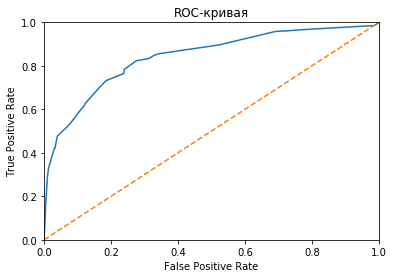

Метрика AUC-ROC для модели дерева решений равна: 0.8410342151936152
Максимальная F1-мера модели Дерево решений равна: 0.5787878787878787


In [15]:
from sklearn.metrics import roc_curve #Импортирую функцию roc_curve для построения ROC-кривой
from sklearn.metrics import roc_auc_score #Импортирую функцию roc_auc_score для определения площади под ROC-кривой 

#Обучаю модель дерево решений на подобранных ранее оптимальных значениях гиперпараметров
tree_model = DecisionTreeClassifier(random_state=12345, 
                                                max_depth=tree_optimal_depth, 
                                                min_samples_split=tree_optimal_split, 
                                                min_samples_leaf=tree_optimal_leaf)
tree_model.fit(features_train, target_train)
tree_predictions = tree_model.predict(features_valid)
#Нахожу вероятности предсказания значений
probabilities_valid = tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

tree_auc_roc = roc_auc_score(target_valid, probabilities_one_valid) #Рассчитываю значение метрики auc_roc
print('Метрика AUC-ROC для модели дерева решений равна:', tree_auc_roc)
print('Максимальная F1-мера модели Дерево решений равна:', max_f1_tree)

Аналогично обучим модель Случайного леса.

In [16]:
from sklearn.ensemble import RandomForestClassifier #Импортирую RandomForestClassifier из библиотеки sklearn

forest_f1_score_list = [] #Создаю пустой список для сбора значений F1 меры
forest_estimators_list = [] #Создаю пустой список настроек гиперпараметра n_estimators
forest_depth_list = [] #Создаю пустой список настроек гиперпараметра max_depth

#Циклом обучаю модель случайного леса при разных значениях max_depth, n_estimators и проверяю метрику F1
for depth in range(2, 14, 2):
    for estim in range(40, 100, 2):
        forest_model = RandomForestClassifier(random_state=12345, 
                                                max_depth=depth, 
                                                n_estimators=estim) 
        forest_model.fit(features_train, target_train)
        forest_predictions = forest_model.predict(features_valid)
        forest_f1_score = f1_score(target_valid, forest_predictions)
        forest_f1_score_list.append(forest_f1_score)
        forest_estimators_list.append(estim)
        forest_depth_list.append(depth)
        print('Для Случайного леса max_depth =', depth, 
              'n_estimators =',estim,
              'метрика f1_score =', forest_f1_score)

#Определяю оптимальные настройки гиперпараметров            
index = forest_f1_score_list.index(max(forest_f1_score_list))
forest_optimal_depth = forest_depth_list[index]
forest_optimal_estimator = forest_estimators_list[index]
max_f1_forest = max(forest_f1_score_list)

print()
print('Максимальная F1-мера модели Случайного леса равна:', max_f1_forest)
print('Оптимальное значение max_depth равно:', forest_optimal_depth)
print('Оптимальное значение n_estimators равно:', forest_optimal_estimator)

Для Случайного леса max_depth = 2 n_estimators = 40 метрика f1_score = 0.19068736141906872
Для Случайного леса max_depth = 2 n_estimators = 42 метрика f1_score = 0.19426048565121412
Для Случайного леса max_depth = 2 n_estimators = 44 метрика f1_score = 0.1986754966887417
Для Случайного леса max_depth = 2 n_estimators = 46 метрика f1_score = 0.22510822510822512
Для Случайного леса max_depth = 2 n_estimators = 48 метрика f1_score = 0.19823788546255508
Для Случайного леса max_depth = 2 n_estimators = 50 метрика f1_score = 0.2178649237472767
Для Случайного леса max_depth = 2 n_estimators = 52 метрика f1_score = 0.19469026548672566
Для Случайного леса max_depth = 2 n_estimators = 54 метрика f1_score = 0.17449664429530198
Для Случайного леса max_depth = 2 n_estimators = 56 метрика f1_score = 0.1580135440180587
Для Случайного леса max_depth = 2 n_estimators = 58 метрика f1_score = 0.1580135440180587
Для Случайного леса max_depth = 2 n_estimators = 60 метрика f1_score = 0.17817371937639195
Для

Построим для модели случайного леса ROC-кривую и рассчитаем метрику AUC-ROC.

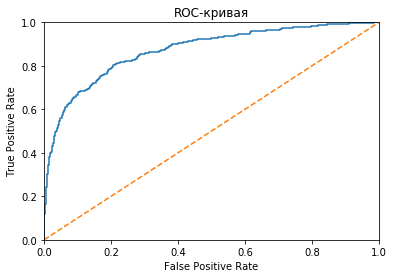

Метрика AUC-ROC для модели Случайного леса равна: 0.8710556458764411
Максимальная F1-мера модели Случайного леса равна: 0.598159509202454


In [17]:
#Обучаю модель случайного леса на подобранных ранее оптимальных значениях гиперпараметров
forest_model = RandomForestClassifier(random_state=12345, 
                                                max_depth=forest_optimal_depth, 
                                                n_estimators=forest_optimal_estimator) 
forest_model.fit(features_train, target_train)
forest_predictions = forest_model.predict(features_valid)

forest_probabilities_valid = forest_model.predict_proba(features_valid)
forest_probabilities_one_valid = forest_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, forest_probabilities_one_valid)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

forest_auc_roc = roc_auc_score(target_valid, forest_probabilities_one_valid)
print('Метрика AUC-ROC для модели Случайного леса равна:', forest_auc_roc)
print('Максимальная F1-мера модели Случайного леса равна:', max_f1_forest)

Обучим модель логистической регрессии.

In [18]:
from sklearn.linear_model import LogisticRegression #Импортирую LogisticRegression из библиотеки sklearn

logistic_model = LogisticRegression(random_state=12345, solver='liblinear')
logistic_model.fit(features_train, target_train) #Обучаю модель

logistic_predictions = logistic_model.predict(features_valid)
logistic_f1_score = f1_score(target_valid, logistic_predictions)
print('Для Логистической регресии F1 =', logistic_f1_score)

Для Логистической регресии F1 = 0.3076923076923077


Построим для модели логистической регрессии ROC-кривую и рассчитаем метрику AUC-ROC.

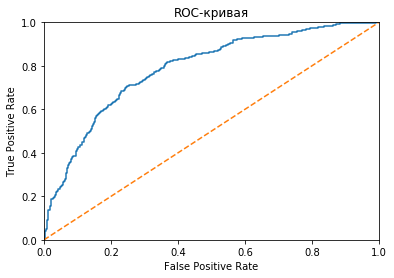

Метрика AUC-ROC для модели Логистической регрессии равна: 0.787586831214898


In [19]:
logistic_probabilities_valid = logistic_model.predict_proba(features_valid)
logistic_probabilities_one_valid = logistic_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, logistic_probabilities_one_valid)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()
logistic_auc_roc = roc_auc_score(target_valid, logistic_probabilities_one_valid)
print('Метрика AUC-ROC для модели Логистической регрессии равна:', logistic_auc_roc)

## Вывод к Шагу 2

На этом шаге без учета дисбаланса обучены три модели, определены оптимальные значения гиперпараметров, рассчитаны значения метрик F1 и AUC-ROC, построены ROC-кривые.
<br>Наилучших значений метрик удалось добиться на модели Случайного леса. Метрика AUC-ROC для модели Случайного леса равна: 0.8647711856450999. Максимальная F1-мера модели Случайного леса равна: 0.5802047781569966. Следовательно данная модель неплохо предсказывает положительный класс целевого признака.
<br>Однако, стоит учесть, что модель была обучена при условии дисбаланса классов. В следующем шаге необходимо уменьшить дисбаланс и привести их соотношение к показателю 1:1.

# 3. Борьба с дисбалансом

### Техника Upsampling

Для уменьшения дисбаланса воспользуемся техникой **upsampling**. Для этого увеличим обучающие выборки элементами положительного класса. Количество таких элементов будет увеличено в 4 раза.

In [20]:
from sklearn.utils import shuffle #Из библиотеки sklearn импортирую функцию shuffle

#Объявляю функцию для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

После увеличения выборки приступаем к обучению моделей и определению метрик качества.

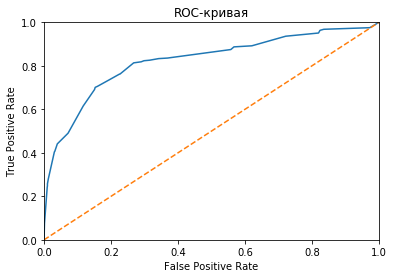

F1-мера модели Дерево решений на увеличенной выборке равна: 0.575925925925926
Метрика AUC-ROC для модели Дерево решений на увеличенной выборке равна: 0.8234278007685487
______________________________________________________________________________________________
Максимальная F1-мера модели Дерево решений до увеличения выборки равна: 0.5787878787878787
Метрика AUC-ROC для модели Дерева решений до увеличения выборки равна: 0.8410342151936152


In [21]:
#Обучаю модель Дерево решений на подобранных ранее оптимальных значениях гиперпараметров и увеличенных выборках
upsampled_tree_model = DecisionTreeClassifier(random_state=12345, 
                                                max_depth=tree_optimal_depth, 
                                                min_samples_split=tree_optimal_split, 
                                                min_samples_leaf=tree_optimal_leaf)
upsampled_tree_model.fit(features_upsampled, target_upsampled)
upsampled_tree_predictions = upsampled_tree_model.predict(features_valid)

#Нахожу вероятности предсказания значений
upsampled_tree_probabilities_valid = upsampled_tree_model.predict_proba(features_valid)
upsampled_tree_probabilities_one_valid = upsampled_tree_probabilities_valid[:, 1]

#Строю ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, upsampled_tree_probabilities_one_valid)

plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

upsampled_tree_f1_score = f1_score(target_valid, upsampled_tree_predictions) #Рассчитываю значение метрики f1
#Рассчитываю значение метрики auc_roc
upsampled_tree_auc_roc = roc_auc_score(target_valid, upsampled_tree_probabilities_one_valid)

print('F1-мера модели Дерево решений на увеличенной выборке равна:', upsampled_tree_f1_score)
print('Метрика AUC-ROC для модели Дерево решений на увеличенной выборке равна:', upsampled_tree_auc_roc)
print('______________________________________________________________________________________________')
print('Максимальная F1-мера модели Дерево решений до увеличения выборки равна:', max_f1_tree)
print('Метрика AUC-ROC для модели Дерева решений до увеличения выборки равна:', tree_auc_roc)

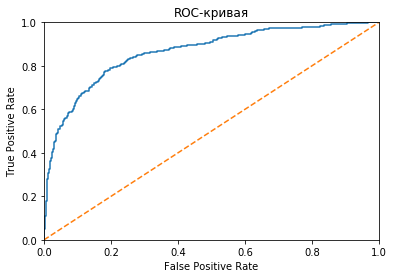

F1-мера модели Случайного леса на увеличенной выборке равна: 0.6263736263736263
Метрика AUC-ROC для модели Случайного леса на увеличенной выборке равна: 0.8640444871415902
______________________________________________________________________________________________
Максимальная F1-мера модели Случайного леса до увеличения выборки равна: 0.598159509202454
Метрика AUC-ROC для модели Случайного леса до увеличения выборки равна: 0.8710556458764411


In [22]:
#Обучаю модель случайного леса на подобранных ранее оптимальных значениях гиперпараметров и увеличенных выборках
upsampled_forest_model = RandomForestClassifier(random_state=12345, 
                                                max_depth=forest_optimal_depth, 
                                                n_estimators=forest_optimal_estimator) 
upsampled_forest_model.fit(features_upsampled, target_upsampled)
upsampled_forest_predictions = upsampled_forest_model.predict(features_valid)

#Нахожу вероятности предсказания значений
upsampled_forest_probabilities_valid = upsampled_forest_model.predict_proba(features_valid)
upsampled_forest_probabilities_one_valid = upsampled_forest_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, upsampled_forest_probabilities_one_valid)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

upsampled_forest_f1_score = f1_score(target_valid, upsampled_forest_predictions)
#Рассчитываю значение метрики auc_roc
upsampled_forest_auc_roc = roc_auc_score(target_valid, upsampled_forest_probabilities_one_valid)

print('F1-мера модели Случайного леса на увеличенной выборке равна:', upsampled_forest_f1_score)
print('Метрика AUC-ROC для модели Случайного леса на увеличенной выборке равна:', upsampled_forest_auc_roc)
print('______________________________________________________________________________________________')
print('Максимальная F1-мера модели Случайного леса до увеличения выборки равна:', max_f1_forest)
print('Метрика AUC-ROC для модели Случайного леса до увеличения выборки равна:', forest_auc_roc)

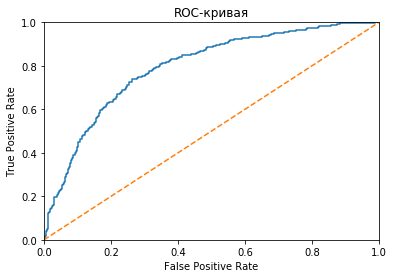

F1-мера модели Логистической регрессии на увеличенной выборке равна: 0.5246753246753246
Метрика AUC-ROC для модели Логистической регрессии на увеличенной выборке равна: 0.7938220514336388
______________________________________________________________________________________________
F1-мера модели Логистической регрессии до увеличения выборки равна: 0.3076923076923077
Метрика AUC-ROC для модели Логистической регрессии до увеличения выборки равна: 0.787586831214898


In [23]:
upsample_logistic_model = LogisticRegression(random_state=12345, solver='liblinear')
upsample_logistic_model.fit(features_upsampled, target_upsampled) #Обучаю модель

upsample_logistic_predictions = upsample_logistic_model.predict(features_valid)
upsample_logistic_f1_score = f1_score(target_valid, upsample_logistic_predictions)

logistic_probabilities_valid = upsample_logistic_model.predict_proba(features_valid)
logistic_probabilities_one_valid = logistic_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, logistic_probabilities_one_valid)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

upsample_logistic_auc_roc = roc_auc_score(target_valid, logistic_probabilities_one_valid)

print('F1-мера модели Логистической регрессии на увеличенной выборке равна:', upsample_logistic_f1_score)
print('Метрика AUC-ROC для модели Логистической регрессии на увеличенной выборке равна:', upsample_logistic_auc_roc)
print('______________________________________________________________________________________________')
print('F1-мера модели Логистической регрессии до увеличения выборки равна:',logistic_f1_score)
print('Метрика AUC-ROC для модели Логистической регрессии до увеличения выборки равна:', logistic_auc_roc)

### Метод "Взвешивания классов"

Еще одним способом борьбы с дисбалансом классов является метод "взвешивания классов", проверим его эффективность на моделях.

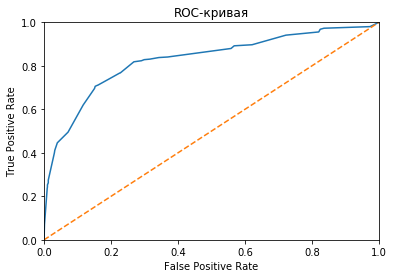

F1-мера модели Дерево решений при "взвешивании классов" равна: 0.5780240073868882
Метрика AUC-ROC для модели дерева решений при "взвешивании классов" равна: 0.8410342151936152


In [24]:
balanced_tree_model = DecisionTreeClassifier(random_state=12345, 
                                                max_depth=tree_optimal_depth, 
                                                min_samples_split=tree_optimal_split, 
                                                min_samples_leaf=tree_optimal_leaf, class_weight='balanced')
balanced_tree_model.fit(features_train, target_train)
balanced_tree_predictions = balanced_tree_model.predict(features_valid)
#Нахожу вероятности предсказания значений
balanced_probabilities_valid = balanced_tree_model.predict_proba(features_valid)
balanced_probabilities_one_valid = balanced_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, balanced_probabilities_one_valid)
#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

balanced_tree_auc_roc = roc_auc_score(target_valid, probabilities_one_valid) #Рассчитываю значение метрики auc_roc
balanced_tree_f1_score = f1_score(target_valid, balanced_tree_predictions)

print('F1-мера модели Дерево решений при "взвешивании классов" равна:', balanced_tree_f1_score)
print('Метрика AUC-ROC для модели дерева решений при "взвешивании классов" равна:', balanced_tree_auc_roc)

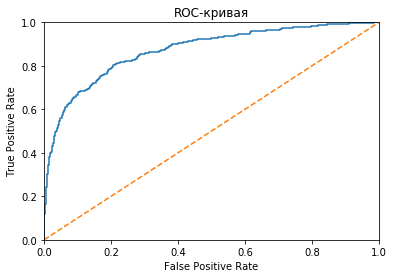

F1-мера модели Случайного леса при "взвешивании классов" равна: 0.5780240073868882
Метрика AUC-ROC для модели Случайного леса при "взвешивании классов" равна: 0.8704198073701841


In [25]:
balanced_forest_model = RandomForestClassifier(random_state=12345, 
                                                max_depth=forest_optimal_depth, 
                                                n_estimators=forest_optimal_estimator, class_weight='balanced') 
balanced_forest_model.fit(features_train, target_train)
balanced_forest_predictions = balanced_forest_model.predict(features_valid)

balanced_forest_probabilities_valid = balanced_forest_model.predict_proba(features_valid)
balanced_forest_probabilities_one_valid = balanced_forest_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, forest_probabilities_one_valid)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

balanced_forest_auc_roc = roc_auc_score(target_valid, balanced_forest_probabilities_one_valid) #Рассчитываю значение метрики auc_roc
balanced_forest_f1_score = f1_score(target_valid, balanced_tree_predictions)

print('F1-мера модели Случайного леса при "взвешивании классов" равна:', balanced_forest_f1_score)
print('Метрика AUC-ROC для модели Случайного леса при "взвешивании классов" равна:', balanced_forest_auc_roc)

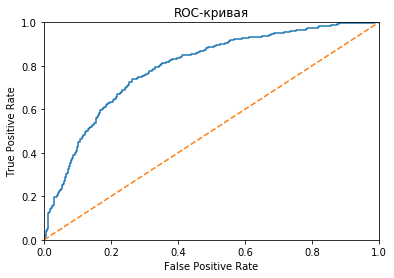

F1-мера модели Логистической регрессии при "взвешивании классов" равна: 0.5302897278314311
Метрика AUC-ROC для модели Логистической регрессии при "взвешивании классов" равна: 0.7937758646172037


In [26]:
balanced_logistic_model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
balanced_logistic_model.fit(features_train, target_train) #Обучаю модель
balanced_logistic_predictions = balanced_logistic_model.predict(features_valid)

balanced_logistic_probabilities_valid = balanced_logistic_model.predict_proba(features_valid)
balanced_logistic_probabilities_one_valid = balanced_logistic_probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, balanced_logistic_probabilities_one_valid)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

balanced_logistic_auc_roc = roc_auc_score(target_valid, balanced_logistic_probabilities_one_valid)
balanced_logistic_f1_score = f1_score(target_valid, balanced_logistic_predictions)

print('F1-мера модели Логистической регрессии при "взвешивании классов" равна:', balanced_logistic_f1_score)
print('Метрика AUC-ROC для модели Логистической регрессии при "взвешивании классов" равна:', balanced_logistic_auc_roc)

Соберем вместе полученные данные по всем метрикам.

In [27]:
columns = ['Модель', 'F1', 'F1-upsampled', 'F1-balanced', 'AUC-ROC', 'AUC-ROC-upsampled', 'AUC-ROC-balanced']
tree = ['Дерево решений', 
        max_f1_tree, 
        upsampled_tree_f1_score,
        balanced_tree_f1_score,
        tree_auc_roc, upsampled_tree_auc_roc,
        balanced_tree_auc_roc
]

forest = ['Случайный лес',
          max_f1_forest,
          upsampled_forest_f1_score,
          balanced_forest_f1_score,
          forest_auc_roc,
          upsampled_forest_auc_roc,
          balanced_forest_auc_roc
]

regression = ['Логистическая регрессия',
             logistic_f1_score,
             upsample_logistic_f1_score,
             balanced_logistic_f1_score,
             logistic_auc_roc,
             upsample_logistic_auc_roc, 
             balanced_logistic_auc_roc
]

table = pd.DataFrame([tree, forest, regression], columns = columns)
display(table)

,Модель,F1,F1-upsampled,F1-balanced,AUC-ROC,AUC-ROC-upsampled,AUC-ROC-balanced
0,Дерево решений,0.578788,0.575926,0.578024,0.841034,0.823428,0.841034
1,Случайный лес,0.598160,0.626374,0.578024,0.871056,0.864044,0.870420
2,Логистическая регрессия,0.307692,0.524675,0.530290,0.787587,0.793822,0.793776


## Вывод к Шагу 3

По результатам уменьшения дисбаланса классов и обучения моделей при сбалансированных условиях, определена лучшая модель, а именно модель случайного леса. F1-мера модели Случайного леса на увеличенной выборке равна: 0.6215895610913406, это наилучший показатель из всех трех моделей. Поэтому модель случйного леса будет протестирована на Шаге 4.

# 4. Тестирование модели

Для тестирования выбрана модель случайного леса, с набором оптимальных значений гиперпараметров.
<br>Прежде чем провести тестирвоание модели, обучим ее заново на выборке, составленной из features_train и features_valid. На большем количестве данных модель должная обучиться лучше.

In [28]:
#Увеличиваю выборки features_train и target_train, добавляя к ним features_valid и target_valid
general_features_train = pd.concat([features_train, features_valid])
general_target_train = pd.concat([target_train, target_valid])

#Проверяю результаты
print(general_features_train.shape)
print(general_target_train.shape)
print()
#Проверяю баланс классов
print(general_target_train.value_counts(normalize = True))

(8000, 11)
(8000,)

0    0.79625
1    0.20375
Name: exited, dtype: float64


Не трудно видеть, что Баланс классов вновь 4:1, требуется устранить дисбаланс. Применим технику **Upsampling**.

In [29]:
general_features_train_upsampled, general_target_train_upsampled = upsample(general_features_train, general_target_train, 4)
print(general_features_train_upsampled.shape)
print(general_target_train_upsampled.shape)

print()
#Проверяю баланс классов после апсемплинга
print(general_target_train_upsampled.value_counts(normalize = True))

(12890, 11)
(12890,)

1    0.505818
0    0.494182
Name: exited, dtype: float64


Теперь соотношение классов близко к 1:1. Можно обучить модель.

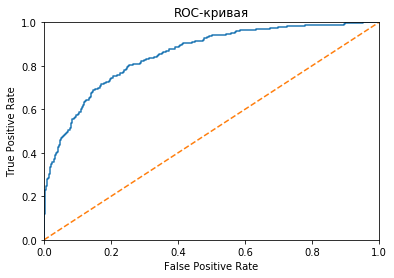

F1-мера модели Случайного леса на тестовой выборке равна: 0.6071044133476857
Метрика AUC-ROC для модели Случайного леса на тестовой выборке равна: 0.854350498418295


In [30]:
#Заново обучаю модель на увеличенных выборках, остальные этапы выполняю аналогично
general_forest_model = RandomForestClassifier(random_state=12345, 
                                                max_depth=forest_optimal_depth, 
                                                n_estimators=forest_optimal_estimator) 
general_forest_model.fit(general_features_train_upsampled, general_target_train_upsampled)
general_forest_model_predictions = general_forest_model.predict(features_test)

forest_probabilities_test = general_forest_model.predict_proba(features_test)
forest_probabilities_one_test = forest_probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, forest_probabilities_one_test)

#Строю ROC-кривую
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #Указываю границу 0,5
plt.xlim([0.0, 1.0]) # Устанавливаю границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') # Подписываю оси x и y "False Positive Rate" и "True Positive Rate" соответственно
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая') # Добавояю к графику заголовок "ROC-кривая"

plt.show()

test_forest_f1_score = f1_score(target_test, general_forest_model_predictions)
test_forest_auc_roc = roc_auc_score(target_test, forest_probabilities_one_test) #Рассчитываю значение метрики auc_roc

print('F1-мера модели Случайного леса на тестовой выборке равна:', test_forest_f1_score)
print('Метрика AUC-ROC для модели Случайного леса на тестовой выборке равна:', test_forest_auc_roc)

## Вывод к Шагу 4

На тесте модель случайного леса показала хороший результат предсказания положительного класса, а именно: F1-мера = 0.6071044133476857; метрика AUC-ROC = 0.854350498418295.

## Общий вывод

Для создания модели по определению оттока клиентов банка был предоставлен датасет содержащий архивные данные об активности клиентов.
<br>Датасет состял из 14 столбцов с данными и 10000 строк. Каждая строка - данные об одном клиенте. Целевой признак содержится в столбце *'exited'* (факт ухода клиента), определяемый бинарной классификацией, а именно 1 == клиент ушел, 0 == клиент НЕ ушел.
<br>Исходные данные требовали подготовки
<br>В столбце *'tenure'* присутствовали пропущенные значения, которые были заменены на 0, считая, что клиент не имеет недвижимости. Также были удалены столбцы, не имеющие отношение к дальнейшему обучению модели, а именно: *'rownumber','customerid','surname'*. Категориальные признаки в столбцах *'geography'* и *'gender'* были преобразованы в численные техникой прямого кодирования - OHE. Финальным шагом подготовки данных стало масштабирование признаков методом стандартизации. Для этого в исходном датасете были выделены признаки и целевой признак, а также проведено разделение на выборки в соотношении 3:1:1.

<br>Далее были обучены модели **Дерево решений, Случайный лес, Логистическая Регрессия**, к ним подобраны оптимальные значения гиперпараметров. Наилучшие показатели метрик получены на модели Случайный лес, а именно F1 = 0.5802047781569966, метрика AUC-ROC = 0.8647711856450999.
<br>Обучение моделей проводилось "в лоб", т.е. без учета дисбаланса классов

<br>Исследование баланса классов после удаления пропусков показало, что ушедших клиентов примерно 20%, НЕ ушедших примерно 80%, что указывает на дисбаланс. В связи с чем для борьбы с дисбалансом были применены два способа - **Upsampling** и **Взвешивание классов**. По итогам борьбы с дисбалансом наилучший показатель по метрике **F1 = 0.621590** определен у модели Случайного леса при использовании способа **Upsampling**.
<br>Именно эта модель была опробована на Шаге 4 при работе на тестовой выборке. Однако, сперва выбранная модель была заново обучена на расширенной выборке *train+valid*.

<br>В итоге удалось достичь следующих показателей **F1-мера = 0.0.6071044133476857**; метрика **AUC-ROC = 0.854350498418295**. Из чего можно сделать вывод, что модель достаточно точно предсказыват положительный класс.